In [18]:
import dspy
import pandas as pd

# Llama configuration
lm = dspy.LM('ollama_chat/llama3.2', api_base='http://localhost:11434')
dspy.settings.configure(lm=lm)

class IdeaRetriever:
    def __init__(self):
        # Initialize ColBERTv2 retriever with necessary parameters
        self.retriever = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')

    def __call__(self, csv_path: str, query: str, k: int = 5):
        """
        Load and search ideas
        
        Args:
            csv_path (str): Path to CSV file
            query (str): Search query
            k (int): Number of results to return
        
        Returns:
            List of retrieved passages
        """
        # Load ideas
        data = pd.read_csv(csv_path)
        ideas = data['Ideas'].astype(str).tolist()
        
        # Add ideas to the retriever's corpus
        # Note: ColBERTv2 typically requires a pre-indexed corpus; this is a placeholder
        # You might need to use a different method to add and index the corpus
        # self.retriever.add_corpus(ideas)  # This line is illustrative; actual method may differ

        # Perform search
        results = self.retriever(query=query, k=k, simplify=True)  # Use the appropriate search method
        return results

def main():
    retriever = IdeaRetriever()
    results = retriever('151_ideas_updated2.csv', 'beauty concepts')
    
    for result in results:
        print(result)

if __name__ == "__main__":
    main()


Beauty | Beauty is a characteristic of an animal, idea, object, person or place that provides a perceptual experience of pleasure or satisfaction. Beauty is studied as part of aesthetics, culture, social psychology, philosophy and sociology. An "ideal beauty" is an entity which is admired, or possesses features widely attributed to beauty in a particular culture, for perfection.
Health in Western Sahara | In Sahrawi ethnic groups, this concept of beauty is embodied through the practice of "leblouh" ("fattening"). Before marriage, girls intentionally overeat and perform limited physical activity for 40 days in order to be attractive for their soon-to-be husbands. Women will repeat this process if they want to gain weight after marriage. It is believed that traditional clothing of these ethnic groups require a heavier body in order to be attractive.
Beauty (disambiguation) | Beauty is an aesthetic characteristic.
Michael Dweck | Michael Dweck (born September 26, 1957) is an American visu

In [21]:
import pandas as pd
import dspy
from sentence_transformers import SentenceTransformer

# Load the CSV file
csv_path = "151_ideas_updated2.csv"
data = pd.read_csv(csv_path)

# Extract the text data to embed
texts = data['Ideas'].astype(str).tolist()  # Replace 'Ideas' with the actual column name

# Initialize the embedder with a Hugging Face model
# You can choose a model from Hugging Face's model hub, e.g., 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embedder = dspy.Embedder(model.encode)

# Compute embeddings
embeddings = embedder(texts)

# Print the shape of the embeddings to verify
print(f"Computed embeddings shape: {embeddings.shape}")

import dspy

# Assuming `embeddings` is a numpy array of your computed embeddings
# and `texts` is the list of original text data

# Initialize the retriever
retriever = dspy.retrievers.Embeddings(corpus=texts, embedder=embedder, k=5)

# Perform a similarity search for a query
query = "beauty concepts"
results = retriever(query)

print("Similarity Search Results:")
for result in results:
    print(result)


Computed embeddings shape: (150, 384)
Similarity Search Results:
passages


In [ ]:
# seems to save a faiss index
import pandas as pd
import dspy
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load the CSV file
csv_path = "151_ideas_updated2.csv"
data = pd.read_csv(csv_path)

# Extract the text data to embed
texts = data['Ideas'].astype(str).tolist()  # Replace 'Ideas' with the actual column name

# Initialize the embedder with a Hugging Face model
# You can choose a model from Hugging Face's model hub, e.g., 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embedder = dspy.Embedder(model.encode)

# Compute embeddings
embeddings = embedder(texts)

# Convert embeddings to a numpy array if not already
if not isinstance(embeddings, np.ndarray):
    embeddings = np.array(embeddings)

# Print the shape of the embeddings to verify
print(f"Computed embeddings shape: {embeddings.shape}")

# Save embeddings to FAISS vector database
vector_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(vector_dim)  # L2 distance (Euclidean)
index_with_ids = faiss.IndexIDMap(index)

# Assign unique IDs to each embedding
ids = np.arange(len(texts))
index_with_ids.add_with_ids(embeddings, ids)

# Save the index to a file
faiss.write_index(index_with_ids, "vector_database.faiss")
print("Embeddings have been saved to 'vector_database.faiss'")

# Assuming `embeddings` is a numpy array of your computed embeddings
# and `texts` is the list of original text data

# Initialize the retriever
retriever = dspy.retrievers.Embeddings(corpus=texts, embedder=embedder, k=5)

# Perform a similarity search for a query
query = "beauty concepts"
results = retriever(query)

print("Similarity Search Results:")
for result in results:
    print(result)


FileNotFoundError: [Errno 2] No such file or directory: 'articles2.json'

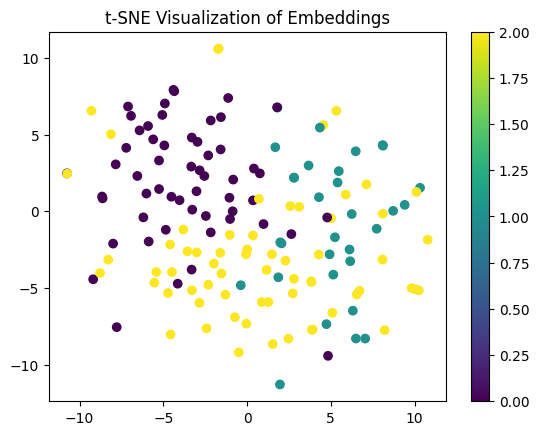

In [ ]:
# visualize embedding results

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have your embeddings data ready
# Example embeddings: a 2D NumPy array of shape (n_samples, n_features)
# embeddings = ...

# Fit k-means clustering
n_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(embeddings)

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("t-SNE Visualization of Embeddings")
plt.colorbar()
plt.show()


In [8]:
import pandas as pd
import dspy
from typing import List, Dict, Optional
import re

class Passage:
    def __init__(self, text, score=None, metadata=None):
        self.text = text
        self.score = score
        self.metadata = metadata or {}

class DataLoader:
    @staticmethod
    def load_ideas(csv_path: str) -> List[Dict]:
        """
        Load and process ideas from a CSV file with robust error handling.
        
        Args:
            csv_path (str): Path to the CSV file
        
        Returns:
            List[Dict]: Processed ideas with title, content, and full text
        """
        try:
            data = pd.read_csv(csv_path, quoting=1)
            
            # Validate required columns
            required_columns = ["Ideas"]
            for col in required_columns:
                if col not in data.columns:
                    raise ValueError(f"CSV must contain a column named '{col}'.")
            
            processed_ideas = []
            for idea in data["Ideas"].dropna().values:
                text = str(idea).strip()
                parts = text.split('-', 1)
                
                title = parts[0].strip() if len(parts) > 1 else ""
                content = parts[1].strip() if len(parts) > 1 else text
                
                processed_ideas.append({
                    "title": title,
                    "content": content,
                    "full_text": text
                })
            
            return processed_ideas
        except FileNotFoundError:
            print(f"Error: File not found at {csv_path}")
            return []
        except pd.errors.EmptyDataError:
            print(f"Error: No data in file {csv_path}")
            return []
        except Exception as e:
            print(f"Unexpected error loading CSV: {e}")
            return []

class SemanticRetriever:
    def __init__(self, ideas: List[Dict]):
        """
        Initialize semantic retriever with ideas.
        
        Args:
            ideas (List[Dict]): Processed ideas to search through
        """
        self.ideas = ideas

    def __call__(self, query: str, k: int = 10) -> List[Passage]:
        """
        Retrieve relevant passages based on query.
        
        Args:
            query (str): Search query
            k (int): Maximum number of results to return
        
        Returns:
            List[Passage]: Relevant passages
        """
        results = []
        query_lower = query.lower()
        
        for idea in self.ideas:
            # More sophisticated matching
            match_score = (
                (query_lower in idea["title"].lower()) * 2 +
                (query_lower in idea["content"].lower())
            )
            
            if match_score > 0:
                results.append(Passage(
                    text=idea["full_text"], 
                    score=match_score
                ))
        
        # Sort by relevance and limit results
        return sorted(results, key=lambda x: x.score, reverse=True)[:k]

class RAGSystem(dspy.Module):
    def __init__(self, retriever, num_docs: int = 3):
        """
        Initialize RAG system with semantic retriever.
        
        Args:
            retriever (SemanticRetriever): Semantic retrieval system
            num_docs (int): Number of documents to retrieve
        """
        super().__init__()
        self.retriever = retriever
        self.num_docs = num_docs
        self.generate_response = dspy.ChainOfThought("context, question -> response")

    def forward(self, question: str) -> str:
        """
        Generate response with retrieved context.
        
        Args:
            question (str): Input question
        
        Returns:
            str: Generated response
        """
        context = self.retriever(question, k=self.num_docs)
        
        if not context:
            return "I couldn't find relevant information to answer this question."
        
        prediction = self.generate_response(
            context="\n".join([p.text for p in context]),
            question=question
        )
        
        return prediction.response

def optimize_rag(retriever, trainset):
    """
    Optimize RAG system using MIPROv2.
    
    Args:
        retriever (SemanticRetriever): Semantic retrieval system
        trainset (List[Dict]): Training examples
    
    Returns:
        Optimized RAG system
    """
    tp = dspy.MIPROv2(
        metric=dspy.evaluate.SemanticF1(decompositional=True),
        auto="medium",
        num_threads=4
    )
    
    optimized_rag = tp.compile(
        RAGSystem(retriever),
        trainset=trainset,
        max_bootstrapped_demos=3,
        max_labeled_demos=3
    )
    
    return optimized_rag

def generate_training_examples() -> List[Dict]:
    """
    Generate training examples for RAG system.
    
    Returns:
        List[Dict]: Training question-response pairs
    """
    return [
        {
            "question": "How can we maximize beauty?",
            "response": "Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation."
        },
        {
            "question": "What is full expression?",
            "response": "Full expression is about understanding oneself when comfortable and learning to channel authentic self-expression. It recognizes that people face barriers like shyness and distraction that can prevent genuine communication. The concept emphasizes the effort required to overcome these obstacles and achieve genuine, uninhibited self-presentation."
        }
    ]

def main():
    """
    Main execution function with comprehensive error handling.
    """
    try:
        # Load ideas
        ideas = DataLoader.load_ideas("151_ideas_updated2.csv")
        
        if not ideas:
            print("No ideas loaded. Exiting.")
            return
        
        # Create retriever
        retriever = SemanticRetriever(ideas)
        
        # Generate training examples
        trainset = generate_training_examples()
        
        # Optimize RAG system
        optimized_rag = optimize_rag(retriever, trainset)
        
        # Test questions
        test_questions = [
            "How do you maximize beauty?",
            "What is the power of full expression?"
        ]
        
        # Execute queries
        for question in test_questions:
            print(f"\nQuestion: {question}")
            response = optimized_rag(question)
            print(f"Response: {response}\n{'-'*50}")
    
    except Exception as e:
        print(f"Unexpected error in main execution: {e}")

if __name__ == "__main__":
    main()

2025/01/24 21:49:02 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 25
minibatch: False
num_candidates: 19
valset size: 1

2025/01/24 21:49:16 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/24 21:49:16 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/01/24 21:49:16 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=19 sets of demonstrations...


Bootstrapping set 1/19
Bootstrapping set 2/19
Bootstrapping set 3/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 4/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 5/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 6/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 8/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 9/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 10/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 11/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 12/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 13/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 14/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 15/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 16/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 17/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 18/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 19/19


  0%|          | 0/1 [00:00<?, ?it/s]2025/01/24 21:49:16 ERROR dspy.teleprompt.bootstrap: Failed to run or to evaluate example {'question': 'How can we maximize beauty?', 'response': 'Maximizing beauty involves fully channeling inner beauty and actively seeking beauty in every situation. This includes disciplining our senses to focus on beauty in our surroundings, appreciating subtle details like flowers and birds, and recognizing beauty as a fundamental virtue requiring conscious implementation.'} with module = Predict(StringSignature(question, ground_truth, system_response -> rationale, ground_truth_key_ideas, system_response_key_ideas, discussion, recall, precision
    instructions="Compare a system's response to the ground truth to compute recall and precision of key ideas.\nYou will first enumerate key ideas in each response, discuss their overlap, and then report recall and precision."
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'inpu

Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Error getting data summary: No LM is loaded..

Running without data aware proposer.

Unexpected error in main execution: 'NoneType' object has no attribute 'kwargs'


In [ ]:
import pandas as pd

def load_ideas(csv_path: str) -> List[Dict]:
    data = pd.read_csv(csv_path, quoting=1)
    if "Ideas" not in data.columns:
        raise ValueError("CSV must contain a column named 'Ideas'.")
    
    processed_ideas = []
    for idea in data["Ideas"].values:
        text = str(idea).strip()
        parts = text.split('-', 1)
        title = parts[0].strip() if len(parts) > 1 else ""
        content = parts[1].strip() if len(parts) > 1 else text
        processed_ideas.append({
            "title": title,
            "content": content,
            "full_text": text
        })
    return processed_ideas

# Load ideas from CSV
ideas = load_ideas("151_ideas_updated2.csv")

In [ ]:
from dspy import Passage

def get_context(query: str, k: int = 3) -> List[Passage]:
    results = [Passage(text=f"Relevant idea: {idea}") for idea in colbertv2_csv(query, k=k)]
    return results